In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
import os
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.layers import Flatten,Dense,Dropout,BatchNormalization
from tensorflow.keras.models import Model,Sequential

from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D

In [ ]:
batch_size = 32
img_height = 150
img_width = 150

In [ ]:
data_dir='/content/drive/MyDrive/SPCC EXPS/ct-ori-dataset/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone'
train=tf.keras.utils.image_dataset_from_directory(data_dir,image_size=(img_height,img_width),
                                                validation_split=0.1,
                                                subset='training',seed=123)
val=tf.keras.utils.image_dataset_from_directory(data_dir,image_size=(img_height,img_width),
                                                validation_split=0.2,
                                                subset='validation',seed=123)

NotFoundError: Could not find directory /content/drive/MyDrive/SPCC EXPS/ct-ori-dataset/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
label_to_class_name = dict(zip(range(len(train.class_names)), train.class_names))
label_to_class_name

NameError: name 'train' is not defined

In [ ]:
for image_batch, labels_batch in train:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 150, 150, 3)
(32,)


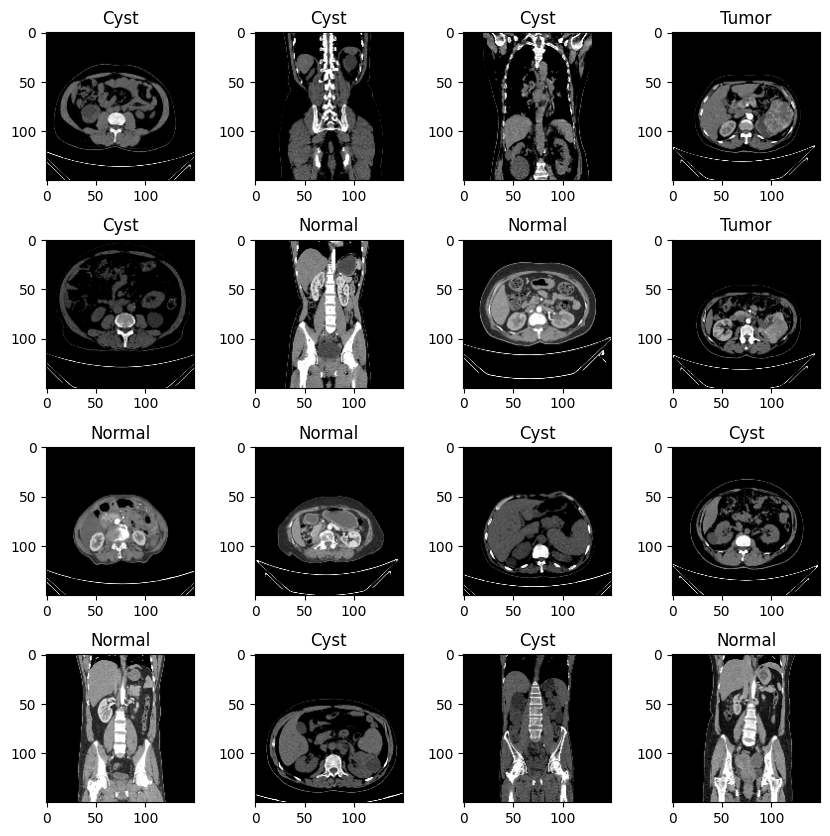

In [ ]:
data_iterator = train.as_numpy_iterator()
batch = data_iterator.next()
fig, ax = plt.subplots(nrows=4, ncols=4, figsize=(10, 10))
for i in range(4):
    for j in range(4):
        index = i * 4 + j
        ax[i, j].imshow(batch[0][index].astype(int))
        ax[i, j].set_title(label_to_class_name[batch[1][index]])
plt.subplots_adjust(wspace=0.4, hspace=0.4)
plt.show()

In [ ]:
train=train.map(lambda x,y:(x/255,y))
val=val.map(lambda x,y:(x/255,y))

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train = train.cache().prefetch(buffer_size=AUTOTUNE)
val = val.cache().prefetch(buffer_size=AUTOTUNE)

# Mobile-Net Training

In [ ]:
mobile_net = Sequential()

pretrained_model= tf.keras.applications.MobileNetV2(include_top=False,
                   input_shape=(150,150,3),
                   pooling='max',classes=4,
                   weights='imagenet')


mobile_net.add(pretrained_model)
mobile_net.add(Flatten())
mobile_net.add(Dense(512, activation='relu'))
mobile_net.add(BatchNormalization())  # Batch Normalization layer
mobile_net.add(Dropout(0.5))

mobile_net.add(Dense(4, activation='softmax'))
pretrained_model.trainable=False

9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
mobile_net.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [ ]:
mobile_net.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 1280)              2257984   
 tional)                                                         
                                                                 
 flatten (Flatten)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 512)               655872    
                                                                 
 batch_normalization (Batch  (None, 512)               2048      
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 2

In [ ]:
epochs=15
history = mobile_net.fit(
  train,
  validation_data=val,
  epochs=epochs
)

Epoch 1/15
303/303 [==============================] - 1205s 4s/step - loss: 0.4182 - accuracy: 0.8520 - val_loss: 0.1432 - val_accuracy: 0.9534
Epoch 2/15
303/303 [==============================] - 278s 920ms/step - loss: 0.1292 - accuracy: 0.9567 - val_loss: 0.0648 - val_accuracy: 0.9818
Epoch 3/15
303/303 [==============================] - 268s 885ms/step - loss: 0.0782 - accuracy: 0.9752 - val_loss: 0.0307 - val_accuracy: 0.9912
Epoch 4/15
303/303 [==============================] - 276s 912ms/step - loss: 0.0568 - accuracy: 0.9830 - val_loss: 0.0202 - val_accuracy: 0.9967
Epoch 5/15
303/303 [==============================] - 254s 839ms/step - loss: 0.0421 - accuracy: 0.9882 - val_loss: 0.0886 - val_accuracy: 0.9688
Epoch 6/15
303/303 [==============================] - 235s 776ms/step - loss: 0.0553 - accuracy: 0.9821 - val_loss: 0.0793 - val_accuracy: 0.9697
Epoch 7/15
303/303 [==============================] - 232s 765ms/step - loss: 0.0376 - accuracy: 0.9870 - val_loss: 0.0135 - v

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss)+1)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

NameError: name 'history' is not defined

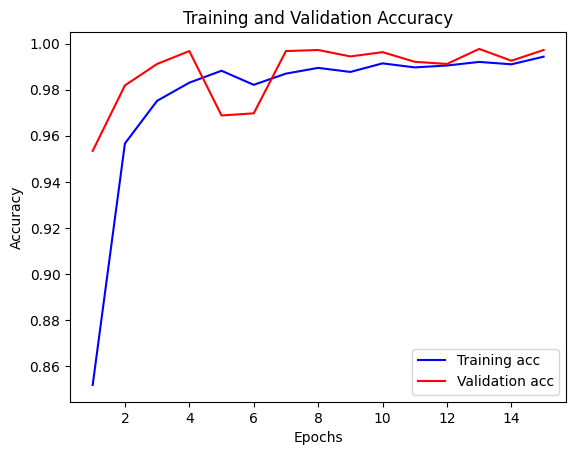

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

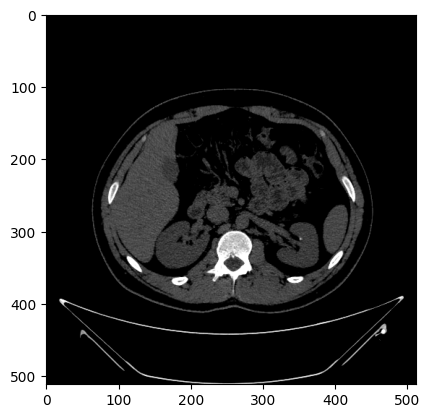

NameError: name 'mobile_net' is not defined

In [ ]:
img = cv2.imread('/content/test.jpg')
plt.imshow(img)
plt.show()
resize = tf.image.resize(img, (150,150))
yhat = mobile_net.predict(np.expand_dims(resize/255, 0))
max_index = np.argmax(yhat)
label_to_class_name[max_index]

In [ ]:
mobile_net.save("model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
label_to_class_name = {0: 'Cyst', 1: 'Normal', 2: 'Stone', 3: 'Tumor'}

# Load Model

In [ ]:
loaded_model = tf.keras.models.load_model("model.h5")

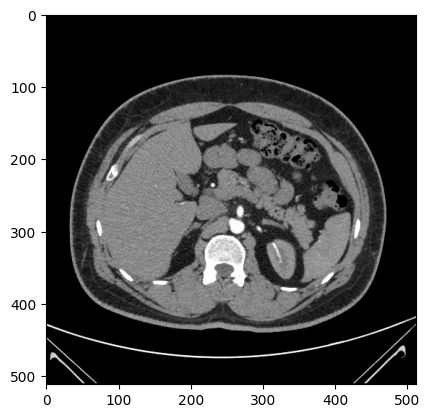

1/1 [==============================] - 0s 40ms/step


'Normal'

In [25]:
img = cv2.imread('/content/Normal- (2).jpg')
plt.imshow(img)
plt.show()
resize = tf.image.resize(img, (150,150))
yhat = loaded_model.predict(np.expand_dims(resize/255, 0))
max_index = np.argmax(yhat)
label_to_class_name[max_index]

# Final Code For Running the Model

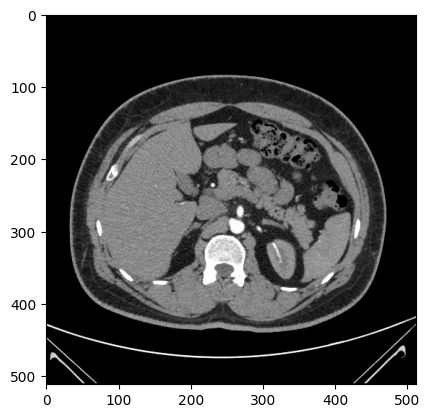

1/1 [==============================] - 1s 772ms/step


'Normal'

In [26]:
import cv2
import tensorflow as tf
import os
from tensorflow import keras
import numpy as np

label_to_class_name = {0: 'Cyst', 1: 'Normal', 2: 'Stone', 3: 'Tumor'}
loaded_model = tf.keras.models.load_model("model.h5")

img = cv2.imread('/content/Normal- (2).jpg')
plt.imshow(img)
plt.show()
resize = tf.image.resize(img, (150,150))
resize = np.expand_dims(resize, 0)  # Expand dimensions once outside the loop
resize = resize / 255  # Normalize once outside the loop

yhat = loaded_model.predict(resize)
max_index = np.argmax(yhat)
label_to_class_name[max_index]
